In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras import optimizers

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [3]:
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

In [4]:
def lags_train_test(data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(data[i-lags:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [5]:
def Xtrain_ytrain(train,test,lags):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = lags_train_test(train_set_scale, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = lags_train_test(inputs, lags)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# n_splits = 5

## Run in loop and lags 5

### Optimizer adam batch size 32 units 100 second layer 100 epochs 10 

In [8]:
cv = TimeSeriesSplit(n_splits=5)
mse = []
for train,test in cv.split(cloud_cover):
    print('TRAIN:', train.shape, 'TEST:', test.shape) 
    train, test = cloud_cover.iloc[train, :], cloud_cover.iloc[test, :]
    train = train.set_index('DateTime')
    test = test.set_index('DateTime')
    
    # X_train, y_train, X_test and y_test
    X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

    # model
    regressor = Sequential()
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(LSTM(units = 100))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32) 
    predict_scaled = regressor.predict(X_test)
    predict = sc.inverse_transform(predict_scaled)
    test['LSTM'] = predict
    lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
    print('lstm mse error lags 5: ', lstm_mse_error)
    print('\n')
    mse.append(lstm_mse_error)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2506, 5, 1)
y_train Shape : (2506, 1)
X_test Shape :  (2510, 5, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/10
79/79 [==============================] - 11s 50ms/step - loss: 0.0363 - val_loss: 0.0037
Epoch 2/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 3/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 4/10
79/79 [==============================] - 2s 25ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/10
79/79 [==============================] - 2s 23ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/10
79/79 [==============================] - 2s 27ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/10
79/79 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/10
79/79 [==============================] - 2s 22ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 9/10
79/79 [==============================] - 2s 25ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 10/10
79/79 [==============================] - 2s 6ms/step
lstm mse error lags 5:  0.00281823614122174

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/10
157/157 [==============================] - 11s 31ms/step - loss: 0.0204 - val_loss: 0.0018
Epoch 2/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 3/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 4/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/10
157/157 [==============================] - 3s 18ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 6/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 8/10
157/157 [==============================] - 3s 20ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/10
79/79 [==============================] - 3s 7ms/step
lstm mse error lags 5:  0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/10
236/236 [==============================] - 13s 27ms/step - loss: 0.0132 - val_loss: 8.9237e-04
Epoch 2/10
236/236 [==============================] - 4s 19ms/step - loss: 0.0028 - val_loss: 9.6790e-04
Epoch 3/10
236/236 [==============================] - 4s 18ms/step - loss: 0.0026 - val_loss: 7.4281e-04
Epoch 4/10
236/236 [==============================] - 5s 19ms/step - loss: 0.0024 - val_loss: 9.2684e-04
Epoch 5/10
236/236 [==============================] - 5s 19ms/step - loss: 0.0021 - val_loss: 7.3324e-04
Epoch 6/10
236/236 [==============================] - 5s 20ms/step - loss: 0.0018 - val_loss: 6.5743e-04
Epoch 7/10
236/236 [==============================] - 5s 21ms/step - loss: 0.0016 - val_loss: 5.6689e-04
Epoch 8/10
236/236 [==============================] - 5s 21ms/step - loss: 0.0014 - val_loss: 3.4690e-04
Epoch 9/10
236/236 [==============================] - 5s 20ms/step - loss: 0.0013 - val_loss: 6.4033e-04
Epoch 10/10
79/79 [==============================] - 2

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/10
314/314 [==============================] - 15s 26ms/step - loss: 0.0105 - val_loss: 0.0040
Epoch 2/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 3/10
314/314 [==============================] - 8s 25ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 4/10
314/314 [==============================] - 7s 23ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 5/10
314/314 [==============================] - 6s 19ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/10
314/314 [==============================] - 7s 21ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/10
79/79 [==============================] - 2s 8ms/step
lstm mse error lags 5:  0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/10
393/393 [==============================] - 15s 21ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 2/10
393/393 [==============================] - 7s 19ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 3/10
393/393 [==============================] - 8s 21ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 4/10
393/393 [==============================] - 7s 19ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/10
393/393 [==============================] - 8s 21ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 6/10
393/393 [==============================] - 8s 19ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10
393/393 [==============================] - 8s 21ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/10
393/393 [==============================] - 8s 19ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/10
393/393 [==============================] - 8s 20ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/10
79/79 [==============================] - 2s 8ms/step
lstm mse error lags 5:  0

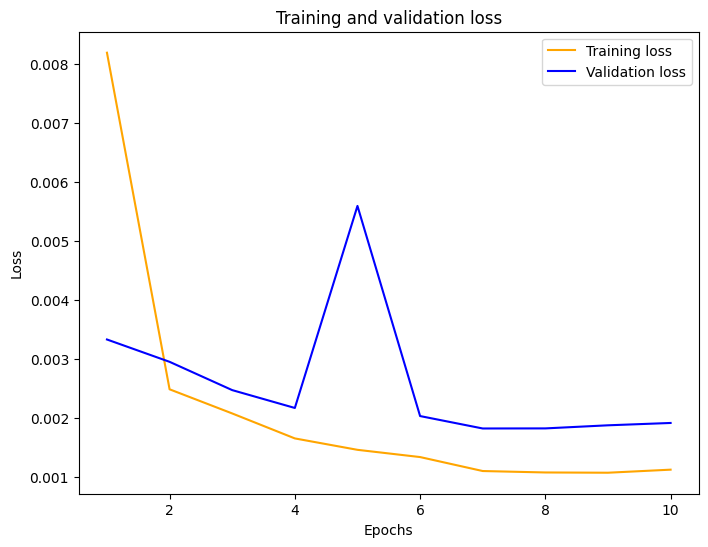

In [9]:
plot_curve(hist)

In [10]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [11]:
test

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.219577
1    2021-12-11 14:56:00        0.188  0.192557
2    2021-12-11 14:58:00        0.310  0.194000
3    2021-12-11 14:59:00        0.351  0.305024
4    2021-12-11 15:00:00        0.222  0.352368
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.173715
2506 2021-12-16 13:59:00        0.169  0.173510
2507 2021-12-16 14:00:00        0.147  0.174371
2508 2021-12-16 14:01:00        0.145  0.155178
2509 2021-12-16 14:02:00        0.144  0.150866

[2510 rows x 3 columns]

In [12]:
print('lstm mse error lag 5: ', lstm_mse_error)

lstm mse error lag 5:  0.0019032697165439303


In [13]:
plot_test(train,test)

In [14]:
lag5 = np.mean(mse)
lag5

0.0015803714088142985

---

## Run in loop and lags 10

### Optimizer adam first layer 50 batch size 32 learning rate 0.05 epochs 10

In [15]:
cv1 = TimeSeriesSplit(n_splits=5)
mse1 = []
for train1,test1 in cv1.split(cloud_cover):
    print('TRAIN:', train1.shape, 'TEST:', test1.shape) 
    train1, test1 = cloud_cover.iloc[train1, :], cloud_cover.iloc[test1, :]
    train1 = train1.set_index('DateTime')
    test1 = test1.set_index('DateTime')
    
    # X_train1, y_train1, X_test1 and y_test1
    X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train1,test1,10)

    # model
    regressor1 = Sequential()
    regressor1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
    regressor1.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.05)
    regressor1.compile(optimizer = opt, loss = 'mean_squared_error')
    hist1 = regressor1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32) 
    predict_scaled1 = regressor1.predict(X_test1)
    predict1 = sc1.inverse_transform(predict_scaled1)
    test1['LSTM'] = predict1
    lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
    print('lstm mse error lags 10 : ', lstm_mse_error1)
    print('\n')
    mse1.append(lstm_mse_error1)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2501, 10, 1)
y_train Shape : (2501, 1)
X_test Shape :  (2510, 10, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
79/79 [==============================] - 5s 21ms/step - loss: 0.3475 - val_loss: 0.0037
Epoch 2/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/10
79/79 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0017917948376481

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
157/157 [==============================] - 6s 14ms/step - loss: 0.1477 - val_loss: 0.0036
Epoch 2/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 9.7879e-04
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 8.2011e-04
Epoch 7/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 8.1573e-04
Epoch 8/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 9/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/10
79/79 [==============================] - 1s 3ms/step
lstm mse error lags 1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
236/236 [==============================] - 7s 12ms/step - loss: 0.0211 - val_loss: 0.0013
Epoch 2/10
236/236 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/10
236/236 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 9.0473e-04
Epoch 4/10
236/236 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 3.1863e-04
Epoch 5/10
236/236 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 6/10
236/236 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 3.1061e-04
Epoch 7/10
236/236 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 2.9560e-04
Epoch 8/10
236/236 [==============================] - 2s 10ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/10
236/236 [==============================] - 2s 8ms/step - loss: 0.0013 - val_loss: 2.7846e-04
Epoch 10/10
79/79 [==============================] - 1s 3ms/step
lstm mse err

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
314/314 [==============================] - 7s 11ms/step - loss: 0.0164 - val_loss: 0.0021
Epoch 2/10
314/314 [==============================] - 4s 14ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 3/10
314/314 [==============================] - 3s 8ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 6/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/10
314/314 [==============================] - 3s 10ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 10/10
79/79 [==============================] - 1s 4ms/step
lstm mse error lags 10 :  0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
392/392 [==============================] - 8s 12ms/step - loss: 0.0140 - val_loss: 0.0021
Epoch 2/10
392/392 [==============================] - 4s 11ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/10
392/392 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/10
392/392 [==============================] - 4s 11ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/10
392/392 [==============================] - 4s 10ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 6/10
392/392 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 7/10
392/392 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/10
392/392 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/10
79/79 [==============================] - 1s 5ms/step
lstm mse error lags 10 :  

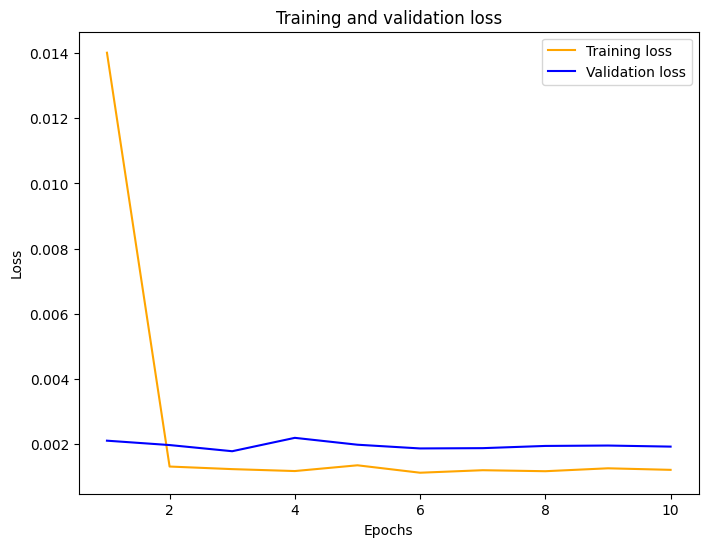

In [16]:
plot_curve(hist1)

In [17]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [18]:
test1

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.211396
1    2021-12-11 14:56:00        0.188  0.184212
2    2021-12-11 14:58:00        0.310  0.183670
3    2021-12-11 14:59:00        0.351  0.294969
4    2021-12-11 15:00:00        0.222  0.347923
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.166392
2506 2021-12-16 13:59:00        0.169  0.165938
2507 2021-12-16 14:00:00        0.147  0.166676
2508 2021-12-16 14:01:00        0.145  0.148413
2509 2021-12-16 14:02:00        0.144  0.143328

[2510 rows x 3 columns]

In [19]:
print('lstm_mse_error lag 10: ', lstm_mse_error1)

lstm_mse_error lag 10:  0.0019135784119679005


In [20]:
plot_test(train1,test1)

In [21]:
mse_lag10 = np.mean(mse1)
mse_lag10

0.0016294383849397662

---

## Run in loop and lags 15

### Optimizer adam batch size 32 units 100 epochs 10 

In [22]:
cv2 = TimeSeriesSplit(n_splits=5)
mse2 = []
for train2,test2 in cv2.split(cloud_cover):
    print('TRAIN:', train2.shape, 'TEST:', test2.shape) 
    train2, test2 = cloud_cover.iloc[train2, :], cloud_cover.iloc[test2, :]
    train2 = train2.set_index('DateTime')
    test2 = test2.set_index('DateTime')
    
    # X_train2, y_train2, X_test2 and y_test2
    X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train2,test2,15)

    # model
    regressor2 = Sequential()
    regressor2.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train2.shape[1], 1)))
    regressor2.add(Dense(units = 1))
    regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist2 = regressor2.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32) 
    predict_scaled2 = regressor2.predict(X_test2)
    predict2 = sc2.inverse_transform(predict_scaled2)
    test2['LSTM'] = predict2
    lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
    print('lstm mse error lags 15 : ', lstm_mse_error2)
    print('\n')
    mse2.append(lstm_mse_error2)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2496, 15, 1)
y_train Shape : (2496, 1)
X_test Shape :  (2510, 15, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
78/78 [==============================] - 6s 42ms/step - loss: 0.0195 - val_loss: 0.0047
Epoch 2/10
78/78 [==============================] - 2s 22ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/10
78/78 [==============================] - 2s 27ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/10
78/78 [==============================] - 2s 28ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/10
78/78 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/10
78/78 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
78/78 [==============================] - 2s 30ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/10
78/78 [==============================] - 2s 24ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/10
79/79 [==============================] - 2s 9ms/step
lstm mse error lags 15 :  0.0025232158599465

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
157/157 [==============================] - 9s 30ms/step - loss: 0.0163 - val_loss: 0.0023
Epoch 2/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/10
157/157 [==============================] - 4s 22ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 4/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/10
157/157 [==============================] - 3s 22ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 7/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/10
157/157 [==============================] - 4s 24ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 10/10
79/79 [==============================] - 1s 8ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
235/235 [==============================] - 10s 26ms/step - loss: 0.0102 - val_loss: 0.0014
Epoch 2/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 8.5182e-04
Epoch 3/10
235/235 [==============================] - 5s 19ms/step - loss: 0.0025 - val_loss: 8.5405e-04
Epoch 4/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0022 - val_loss: 5.9179e-04
Epoch 5/10
235/235 [==============================] - 5s 21ms/step - loss: 0.0019 - val_loss: 6.3928e-04
Epoch 6/10
235/235 [==============================] - 5s 22ms/step - loss: 0.0017 - val_loss: 4.5579e-04
Epoch 7/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0016 - val_loss: 6.3607e-04
Epoch 8/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0015 - val_loss: 5.4425e-04
Epoch 9/10
235/235 [==============================] - 5s 22ms/step - loss: 0.0014 - val_loss: 4.4103e-04
Epoch 10/10
79/79 [==============================] - 1s 8m

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
314/314 [==============================] - 12s 25ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 2/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 3/10
314/314 [==============================] - 7s 23ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/10
314/314 [==============================] - 7s 22ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/10
314/314 [==============================] - 7s 22ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 6/10
314/314 [==============================] - 7s 22ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/10
314/314 [==============================] - 7s 22ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/10
314/314 [==============================] - 7s 22ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/10
314/314 [==============================] - 7s 21ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/10
79/79 [==============================] - 1s 7ms/step
lstm mse error lags 15 : 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
392/392 [==============================] - 13s 24ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 2/10
392/392 [==============================] - 9s 23ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 3/10
392/392 [==============================] - 10s 24ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 4/10
392/392 [==============================] - 9s 24ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/10
392/392 [==============================] - 9s 23ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/10
392/392 [==============================] - 9s 23ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 7/10
392/392 [==============================] - 9s 23ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/10
392/392 [==============================] - 9s 23ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/10
392/392 [==============================] - 10s 25ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/10
79/79 [==============================] - 1s 8ms/step
lstm mse error lags 15 

In [50]:
regressor2.save('model_lag15_cv.h5')

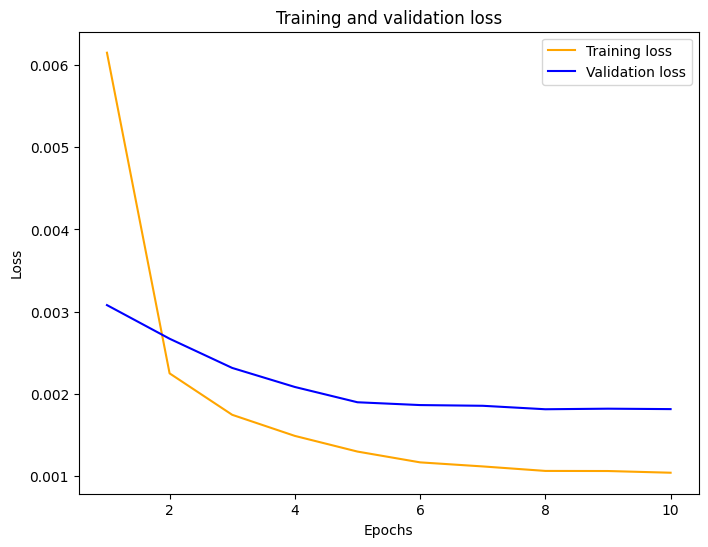

In [23]:
plot_curve(hist2)

In [24]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [25]:
test2

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.214376
1    2021-12-11 14:56:00        0.188  0.187348
2    2021-12-11 14:58:00        0.310  0.188521
3    2021-12-11 14:59:00        0.351  0.297883
4    2021-12-11 15:00:00        0.222  0.348067
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.169531
2506 2021-12-16 13:59:00        0.169  0.169310
2507 2021-12-16 14:00:00        0.147  0.170173
2508 2021-12-16 14:01:00        0.145  0.151220
2509 2021-12-16 14:02:00        0.144  0.146868

[2510 rows x 3 columns]

In [26]:
print('lstm_mse_error lag 15 : ', lstm_mse_error2)

lstm_mse_error lag 15 :  0.0018058790817660239


In [27]:
plot_test(train2,test2)

In [28]:
mse_lag15 = np.mean(mse2)
mse_lag15

0.0014512390305089326

---

## Run in loop and lags 20

### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [29]:
cv3 = TimeSeriesSplit(n_splits=5)
mse3 = []
for train3,test3 in cv3.split(cloud_cover):
    print('TRAIN:', train3.shape, 'TEST:', test3.shape) 
    train3, test3 = cloud_cover.iloc[train3, :], cloud_cover.iloc[test3, :]
    train3 = train3.set_index('DateTime')
    test3 = test3.set_index('DateTime')
    
    # X_train3, y_train3, X_test3 and y_test3
    X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train3,test3,20)

    # model
    regressor3 = Sequential()
    regressor3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1], 1)))
    regressor3.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.005)
    regressor3.compile(optimizer = opt, loss = 'mean_squared_error')
    hist3 = regressor3.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32) 
    predict_scaled3 = regressor3.predict(X_test3)
    predict3 = sc3.inverse_transform(predict_scaled3)
    test3['LSTM'] = predict3
    lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
    print('lstm mse error lags 20 : ', lstm_mse_error3)
    print('\n')
    mse3.append(lstm_mse_error3)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2491, 20, 1)
y_train Shape : (2491, 1)
X_test Shape :  (2510, 20, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
78/78 [==============================] - 6s 31ms/step - loss: 0.0136 - val_loss: 0.0036
Epoch 2/10
78/78 [==============================] - 1s 18ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/10
78/78 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
78/78 [==============================] - 1s 16ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/10
78/78 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/10
78/78 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/10
78/78 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/10
78/78 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/10
78/78 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/10
79/79 [==============================] - 1s 5ms/step
lstm mse error lags 20 :  0.0018978303606766

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
157/157 [==============================] - 7s 20ms/step - loss: 0.0115 - val_loss: 0.0020
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 4/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 7.8326e-04
Epoch 5/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 9.6305e-04
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 6.8135e-04
Epoch 7/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 7.0361e-04
Epoch 8/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 7.4595e-04
Epoch 9/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 7.4234e-04
Epoch 10/10
79/79 [==============================] - 1s 5ms/step
ls

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
235/235 [==============================] - 8s 17ms/step - loss: 0.0064 - val_loss: 6.7037e-04
Epoch 2/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0019 - val_loss: 5.1535e-04
Epoch 3/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 5.5677e-04
Epoch 4/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 4.1928e-04
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0013 - val_loss: 3.3665e-04
Epoch 6/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 2.8561e-04
Epoch 7/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0011 - val_loss: 3.2305e-04
Epoch 8/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0011 - val_loss: 3.5052e-04
Epoch 9/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0011 - val_loss: 2.9547e-04
Epoch 10/10
79/79 [==============================] - 2s

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
314/314 [==============================] - 11s 19ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 2/10
314/314 [==============================] - 5s 17ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 3/10
314/314 [==============================] - 5s 17ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/10
314/314 [==============================] - 6s 20ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 5/10
314/314 [==============================] - 6s 18ms/step - loss: 9.8576e-04 - val_loss: 0.0017
Epoch 6/10
314/314 [==============================] - 5s 17ms/step - loss: 9.1626e-04 - val_loss: 0.0016
Epoch 7/10
314/314 [==============================] - 5s 17ms/step - loss: 8.8883e-04 - val_loss: 0.0017
Epoch 8/10
314/314 [==============================] - 5s 17ms/step - loss: 9.1027e-04 - val_loss: 0.0017
Epoch 9/10
314/314 [==============================] - 5s 17ms/step - loss: 8.8607e-04 - val_loss: 0.0018
Epoch 10/10
79/79 [==============================] - 1s 6ms/step
lstm 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
392/392 [==============================] - 11s 18ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 2/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/10
392/392 [==============================] - 7s 17ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/10
79/79 [==============================] - 1s 6ms/step
lstm mse error lags 20 : 

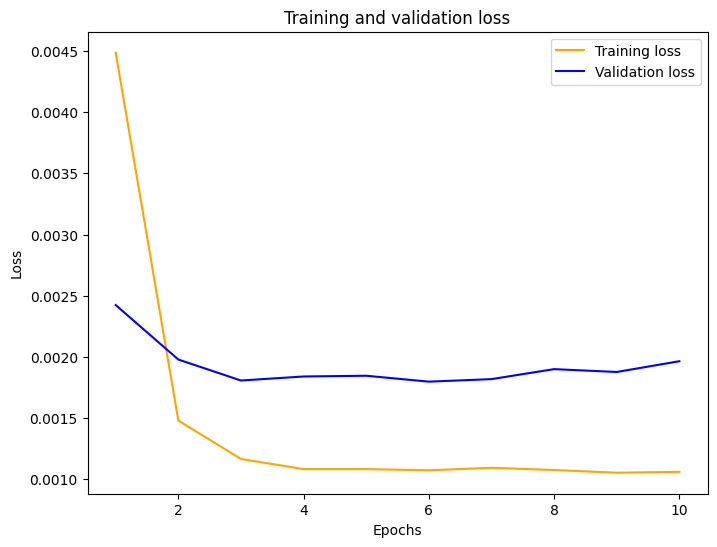

In [30]:
plot_curve(hist3)

In [31]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [32]:
test3

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.224294
1    2021-12-11 14:56:00        0.188  0.195814
2    2021-12-11 14:58:00        0.310  0.198215
3    2021-12-11 14:59:00        0.351  0.315308
4    2021-12-11 15:00:00        0.222  0.360876
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.179031
2506 2021-12-16 13:59:00        0.169  0.178909
2507 2021-12-16 14:00:00        0.147  0.179838
2508 2021-12-16 14:01:00        0.145  0.159684
2509 2021-12-16 14:02:00        0.144  0.155996

[2510 rows x 3 columns]

In [33]:
print('lstm_mse_error lags 20 : ', lstm_mse_error3)

lstm_mse_error lags 20 :  0.0019548798146392637


In [34]:
plot_test(train3,test3)

In [35]:
mse_lag20 = np.mean(mse3)
mse_lag20

0.0013107910770240227

---

## Run in loop and lags 25

### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [36]:
cv4 = TimeSeriesSplit(n_splits=5)
mse4 = []
for train4,test4 in cv4.split(cloud_cover):
    print('TRAIN:', train4.shape, 'TEST:', test4.shape) 
    train4, test4 = cloud_cover.iloc[train4, :], cloud_cover.iloc[test4, :]
    train4 = train4.set_index('DateTime')
    test4 = test4.set_index('DateTime')
    
    # X_train4, y_train4, X_test4 and y_test4
    X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train4,test4,25)

    # model
    regressor4 = Sequential()
    regressor4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train4.shape[1], 1)))
    regressor4.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.005)
    regressor4.compile(optimizer = opt, loss = 'mean_squared_error')
    hist4 = regressor4.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 10, batch_size = 32) 
    predict_scaled4 = regressor4.predict(X_test4)
    predict4 = sc4.inverse_transform(predict_scaled4)
    test4['LSTM'] = predict4
    lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
    print('lstm mse error lags 25 : ', lstm_mse_error4)
    print('\n')
    mse4.append(lstm_mse_error4)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2486, 25, 1)
y_train Shape : (2486, 1)
X_test Shape :  (2510, 25, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
78/78 [==============================] - 7s 33ms/step - loss: 0.0375 - val_loss: 0.0038
Epoch 2/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 3/10
78/78 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/10
78/78 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/10
78/78 [==============================] - 2s 20ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/10
78/78 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/10
78/78 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/10
78/78 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/10
79/79 [==============================] - 1s 5ms/step
lstm mse error lags 25 :  0.0019260156916361

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
157/157 [==============================] - 7s 21ms/step - loss: 0.0129 - val_loss: 0.0017
Epoch 2/10
157/157 [==============================] - 3s 17ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 3/10
157/157 [==============================] - 3s 16ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/10
157/157 [==============================] - 3s 16ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/10
157/157 [==============================] - 3s 16ms/step - loss: 0.0020 - val_loss: 8.8338e-04
Epoch 6/10
157/157 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 7.7462e-04
Epoch 7/10
157/157 [==============================] - 3s 17ms/step - loss: 0.0016 - val_loss: 7.3719e-04
Epoch 8/10
157/157 [==============================] - 2s 16ms/step - loss: 0.0015 - val_loss: 8.2827e-04
Epoch 9/10
157/157 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 8.0454e-04
Epoch 10/10
79/79 [==============================] - 1s 7ms/step
lstm m

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
235/235 [==============================] - 8s 17ms/step - loss: 0.0078 - val_loss: 7.2396e-04
Epoch 2/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0022 - val_loss: 8.3367e-04
Epoch 3/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0017 - val_loss: 4.4275e-04
Epoch 4/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0015 - val_loss: 3.7820e-04
Epoch 5/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0013 - val_loss: 3.5026e-04
Epoch 6/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 3.0061e-04
Epoch 7/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0012 - val_loss: 4.4661e-04
Epoch 8/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0012 - val_loss: 2.8185e-04
Epoch 9/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0011 - val_loss: 2.7775e-04
Epoch 10/10
79/79 [==============================] - 1s

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
313/313 [==============================] - 12s 24ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 3/10
313/313 [==============================] - 5s 17ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 4/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/10
313/313 [==============================] - 5s 16ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 9.6582e-04 - val_loss: 0.0017
Epoch 7/10
313/313 [==============================] - 5s 16ms/step - loss: 9.2727e-04 - val_loss: 0.0018
Epoch 8/10
313/313 [==============================] - 5s 16ms/step - loss: 8.9261e-04 - val_loss: 0.0017
Epoch 9/10
313/313 [==============================] - 5s 15ms/step - loss: 9.2534e-04 - val_loss: 0.0017
Epoch 10/10
79/79 [==============================] - 1s 6ms/step
lstm mse 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
392/392 [==============================] - 12s 18ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 2/10
392/392 [==============================] - 7s 17ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 3/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/10
392/392 [==============================] - 6s 17ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 5/10
392/392 [==============================] - 7s 18ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/10
392/392 [==============================] - 8s 19ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/10
392/392 [==============================] - 7s 18ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/10
392/392 [==============================] - 7s 17ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/10
392/392 [==============================] - 8s 19ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/10
79/79 [==============================] - 1s 7ms/step
lstm mse error lags 25 : 

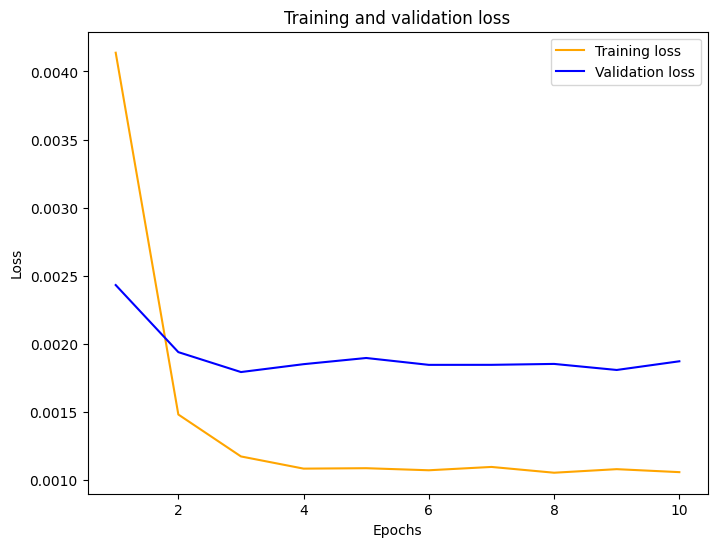

In [37]:
plot_curve(hist4)

In [38]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [39]:
test4

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.217956
1    2021-12-11 14:56:00        0.188  0.189331
2    2021-12-11 14:58:00        0.310  0.194720
3    2021-12-11 14:59:00        0.351  0.313442
4    2021-12-11 15:00:00        0.222  0.346192
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.172698
2506 2021-12-16 13:59:00        0.169  0.172742
2507 2021-12-16 14:00:00        0.147  0.173624
2508 2021-12-16 14:01:00        0.145  0.152608
2509 2021-12-16 14:02:00        0.144  0.150964

[2510 rows x 3 columns]

In [40]:
print('lstm_mse_error lags 25 : ', lstm_mse_error4)

lstm_mse_error lags 25 :  0.0018642705966610638


In [41]:
plot_test(train4,test4)

In [42]:
mse_lag25 = np.mean(mse4)
mse_lag25

0.0012868492072486122

---

## Run in loop and lags 30

### Optimizer RMSprop batch size 32 first layer 50 second layer 50 

In [43]:
cv5 = TimeSeriesSplit(n_splits=5)
mse5 = []
for train5,test5 in cv5.split(cloud_cover):
    print('TRAIN:', train5.shape, 'TEST:', test5.shape) 
    train5, test5 = cloud_cover.iloc[train5, :], cloud_cover.iloc[test5, :]
    train5 = train5.set_index('DateTime')
    test5 = test5.set_index('DateTime')
    
    # X_train5, y_train5, X_test5 and y_test5
    X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train5,test5,30)

    # model
    regressor5 = Sequential()
    regressor5.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train5.shape[1], 1)))
    regressor5.add(LSTM(units = 50))
    regressor5.add(Dense(units = 1))
    regressor5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error')
    hist5 = regressor5.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 10, batch_size = 32) 
    predict_scaled5 = regressor5.predict(X_test5)
    predict5 = sc5.inverse_transform(predict_scaled5)
    test5['LSTM'] = predict5
    lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
    print('lstm mse error lags 30 : ', lstm_mse_error5)
    print('\n')
    mse5.append(lstm_mse_error5)

TRAIN: (2511,) TEST: (2510,)
X_train Shape : (2481, 30, 1)
y_train Shape : (2481, 1)
X_test Shape :  (2510, 30, 1)
y_test Shape :  (2510, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
78/78 [==============================] - 12s 64ms/step - loss: 0.0193 - val_loss: 0.0197
Epoch 2/10
78/78 [==============================] - 3s 39ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 3/10
78/78 [==============================] - 3s 40ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 4/10
78/78 [==============================] - 3s 39ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 5/10
78/78 [==============================] - 3s 40ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/10
78/78 [==============================] - 3s 39ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/10
78/78 [==============================] - 3s 39ms/step - loss: 0.0028 - val_loss: 0.0096
Epoch 8/10
78/78 [==============================] - 3s 41ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/10
78/78 [==============================] - 3s 41ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/10
79/79 [==============================] - 2s 11ms/step
lstm mse error lags 30 :  0.00168880709050

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
156/156 [==============================] - 18s 61ms/step - loss: 0.0139 - val_loss: 0.0021
Epoch 2/10
156/156 [==============================] - 7s 44ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 3/10
156/156 [==============================] - 7s 46ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/10
156/156 [==============================] - 7s 43ms/step - loss: 0.0027 - val_loss: 8.4488e-04
Epoch 5/10
156/156 [==============================] - 7s 44ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/10
156/156 [==============================] - 7s 45ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/10
156/156 [==============================] - 7s 44ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/10
156/156 [==============================] - 7s 44ms/step - loss: 0.0018 - val_loss: 7.5609e-04
Epoch 9/10
156/156 [==============================] - 7s 45ms/step - loss: 0.0017 - val_loss: 8.3749e-04
Epoch 10/10
79/79 [==============================] - 3s 12ms/step
lstm mse err

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
235/235 [==============================] - 17s 42ms/step - loss: 0.0098 - val_loss: 0.0015
Epoch 2/10
235/235 [==============================] - 9s 36ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 3/10
235/235 [==============================] - 9s 40ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 4/10
235/235 [==============================] - 10s 41ms/step - loss: 0.0020 - val_loss: 3.2453e-04
Epoch 5/10
235/235 [==============================] - 9s 40ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/10
235/235 [==============================] - 9s 40ms/step - loss: 0.0016 - val_loss: 2.8876e-04
Epoch 7/10
235/235 [==============================] - 10s 41ms/step - loss: 0.0015 - val_loss: 5.7386e-04
Epoch 8/10
235/235 [==============================] - 10s 41ms/step - loss: 0.0014 - val_loss: 3.5350e-04
Epoch 9/10
235/235 [==============================] - 9s 39ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/10
79/79 [==============================] - 3s 13ms/step
lstm 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
313/313 [==============================] - 20s 42ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 2/10
313/313 [==============================] - 11s 36ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/10
313/313 [==============================] - 11s 36ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/10
313/313 [==============================] - 12s 38ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/10
313/313 [==============================] - 13s 42ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/10
313/313 [==============================] - 15s 48ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 7/10
313/313 [==============================] - 13s 40ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/10
313/313 [==============================] - 10s 31ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/10
79/79 [==============================] - 2s 13ms/step
lstm mse error l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
392/392 [==============================] - 19s 34ms/step - loss: 0.0077 - val_loss: 0.0093
Epoch 2/10
392/392 [==============================] - 12s 30ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 3/10
392/392 [==============================] - 12s 31ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/10
392/392 [==============================] - 15s 37ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/10
392/392 [==============================] - 15s 39ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/10
392/392 [==============================] - 16s 42ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/10
392/392 [==============================] - 17s 43ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/10
392/392 [==============================] - 20s 52ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/10
392/392 [==============================] - 18s 47ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/10
79/79 [==============================] - 3s 16ms/step
lstm mse error l

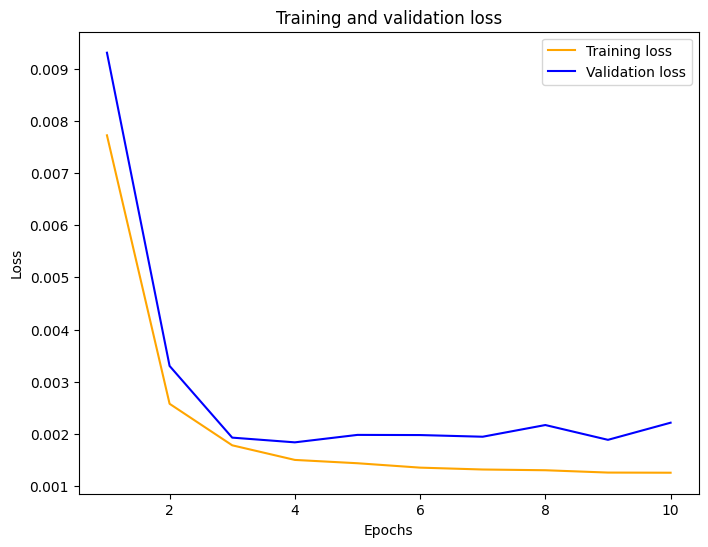

In [44]:
plot_curve(hist5)

In [45]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [46]:
test5

DateTime  cloud_cover      LSTM
0    2021-12-11 14:55:00        0.183  0.195513
1    2021-12-11 14:56:00        0.188  0.166386
2    2021-12-11 14:58:00        0.310  0.170801
3    2021-12-11 14:59:00        0.351  0.290263
4    2021-12-11 15:00:00        0.222  0.330363
...                  ...          ...       ...
2505 2021-12-16 13:58:00        0.168  0.151639
2506 2021-12-16 13:59:00        0.169  0.151551
2507 2021-12-16 14:00:00        0.147  0.152464
2508 2021-12-16 14:01:00        0.145  0.131603
2509 2021-12-16 14:02:00        0.144  0.129277

[2510 rows x 3 columns]

In [47]:
print('lstm_mse_error lags 30 : ', lstm_mse_error5)

lstm_mse_error lags 30 :  0.0022039164104346357


In [48]:
plot_test(train5,test5)

In [49]:
mse_lag30 = np.mean(mse5)
mse_lag30

0.0016960408789736662

---

In [51]:
regressor.save('model_lag5_cv5.h5')
regressor1.save('model_lag10_cv5.h5')
regressor2.save('model_lag15_cv5.h5')
regressor3.save('model_lag20_cv5.h5')
regressor4.save('model_lag25_cv5.h5')
regressor5.save('model_lag30_cv5.h5')